# PDP Environment

In [2]:
import sys; sys.path.append(2*"../")

from typing import Optional

import numpy as np
import torch
from tensordict.tensordict import TensorDict

from torchrl.data import (
    BoundedTensorSpec,
    CompositeSpec,
    UnboundedContinuousTensorSpec,
    UnboundedDiscreteTensorSpec,
)

from rl4co.envs.utils import batch_to_scalar
from rl4co.envs.base import RL4COEnvBase


/home/botu/Dev/rl4co/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def _reset(self, td: Optional[TensorDict] = None, batch_size=None) -> TensorDict:
    # Initialize locations
    init_locs = td["locs"] if td is not None else None
    if batch_size is None:
        batch_size = self.batch_size if init_locs is None else init_locs.shape[:-2]
    self.device = device = (
        init_locs.device if init_locs is not None else self.device
    )
    if init_locs is None:
        init_locs = self.generate_data(batch_size=batch_size)['locs'].to(device)

    # Pick is 1, deliver is 0 [batch_size, graph_size+1], [1,1...1, 0...0]
    to_deliver = torch.cat([torch.ones(*batch_size, self.num_loc // 2 + 1, dtype=torch.bool, device=device),
        torch.zeros(*batch_size, self.num_loc // 2, dtype=torch.bool, device=device)], dim=-1) 
    
    # Cannot visit depot at first step # [0,1...1] so set not available
    available = torch.ones(
        (*batch_size, self.num_loc + 1), dtype=torch.bool, device=device
    )
    action_mask = ~available.contiguous() # [batch_size, graph_size+1]
    action_mask[..., 0] = 1 # First step is always the depot

    # Other variables
    current_node = torch.zeros((*batch_size, 1), dtype=torch.int64, device=device)
    i = torch.zeros((*batch_size, 1), dtype=torch.int64, device=device)


    return TensorDict(
        {
            "locs": init_locs, # init_locs [..., 0] is depot
            "current_node": current_node,
            "to_deliver": to_deliver,
            "available": available,
            "i": i,
            "action_mask": action_mask,
        },
        batch_size=batch_size,
    )

In [4]:
def _make_spec(self, td_params: TensorDict):
    """Make the observation and action specs from the parameters."""
    self.observation_spec = CompositeSpec(
        locs=BoundedTensorSpec(
            minimum=self.min_loc,
            maximum=self.max_loc,
            shape=(self.num_loc, 2),
            dtype=torch.float32,
        ),
        current_node=UnboundedDiscreteTensorSpec(
            shape=(1),
            dtype=torch.int64,
        ),
        to_deliver=UnboundedDiscreteTensorSpec(
            shape=(1),
            dtype=torch.int64,
        ),
        i=UnboundedDiscreteTensorSpec(
            shape=(1),
            dtype=torch.int64,
        ),
        action_mask=UnboundedDiscreteTensorSpec(
            shape=(self.num_loc),
            dtype=torch.bool,
        ),
        shape=(),
    )
    self.input_spec = self.observation_spec.clone()
    self.action_spec = BoundedTensorSpec(
        shape=(1,),
        dtype=torch.int64,
        minimum=0,
        maximum=self.num_loc,
    )
    self.reward_spec = UnboundedContinuousTensorSpec(shape=(1,))
    self.done_spec = UnboundedDiscreteTensorSpec(shape=(1,), dtype=torch.bool)

In [5]:
def generate_data(self, batch_size) -> TensorDict:

    # Batch size input check
    batch_size = [batch_size] if isinstance(batch_size, int) else batch_size

    # Initialize the locations (including the depot which is always the first node)
    locs = (
        torch.FloatTensor(*batch_size, self.num_loc + 1, 2)
        .uniform_(self.min_loc, self.max_loc)
        .to(self.device)
    )
    return TensorDict({"locs": locs}, batch_size=batch_size,)

In [6]:
def get_reward(self, td, actions) -> TensorDict:
    
    assert (actions[:, 0]==0).all(), "Not starting at depot"
    assert (torch.arange(actions.size(1), out=actions.data.new()).view(1, -1).expand_as(actions) == actions.data.sort(1)[0]).all(), "Not visiting all nodes"

    visited_time = torch.argsort(actions, 1)  # index of pickup less than index of delivery 
    assert (visited_time[:, 1:actions.size(1) // 2 + 1] < visited_time[:, actions.size(1) // 2 + 1:]).all(), "Deliverying without pick-up"
    
    # Gather locations in the order of actions and get reward = -(total distance)
    locs = td['locs'].gather(1, actions.unsqueeze(-1).expand_as(td['locs']))  # [batch, graph_size+1, 2]
    locs_next = torch.roll(locs, 1, dims=1) 
    return -(locs_next - locs).norm(p=2, dim=2).sum(1)

   

In [7]:
def _step(self, td: TensorDict) -> TensorDict:
    current_node = td["action"]
    num_loc = td['locs'].shape[-2] - 1 # except depot

    # Pickup and delivery node pair of selected node
    new_to_deliver = (current_node +  num_loc // 2) % (num_loc + 1)
    
    # Set available to 0 (i.e., we visited the node)
    available = td["available"].scatter(
        -1, current_node.unsqueeze(-1).expand_as(td["action_mask"]), 0
    )

    to_deliver = td["to_deliver"].scatter(
        -1, new_to_deliver.unsqueeze(-1).expand_as(td["to_deliver"]), 1
    )

    # # Action is feasible if the node is not visited and is to deliver
    action_mask = torch.logical_and(available, to_deliver)

    # We are done there are no unvisited locations
    done = torch.count_nonzero(available, dim=-1) == 0

    # The reward is calculated outside via get_reward for efficiency, so we set it to -inf here
    reward = torch.ones_like(done) * float("-inf")

    # The output must be written in a ``"next"`` entry
    return TensorDict(
        {
            "next": {
                "locs": td["locs"],
                "current_node": current_node,
                "available": available,
                "to_deliver": to_deliver,
                "i": td["i"] + 1,
                "action_mask": action_mask,
                "reward": reward,
                "done": done,
            }
        },
        td.shape,
    )

In [8]:
class PDPEnv(RL4COEnvBase):
    name = "pdp"

    def __init__(
        self,
        num_loc: int = 10,
        min_loc: float = 0,
        max_loc: float = 1,
        td_params: TensorDict = None,
        seed: int = None,
        device: str = "cpu",
    ):  
        # If num_loc is not even, we add one to make it even
        if num_loc % 2 == 1:
            print("Warning: num_loc is not even. Adding one node to make it even.")
            num_loc += 1
            
        self.num_loc = num_loc
        self.min_loc = min_loc
        self.max_loc = max_loc

        super().__init__(device=device, batch_size=[])
        self._make_spec(td_params)
        if seed is None:
            seed = torch.empty((), dtype=torch.int64).random_().item()
        self.set_seed(seed)

    # Helpers: _make_step and gen_params
    # gen_params = gen_params # we don't use it for this case. See notebook 0
    _make_spec = _make_spec

    # Mandatory methods: _step, _reset and _set_seed
    _reset = _reset
    _step = _step

    # Get reward
    get_reward = get_reward

    # Data
    generate_data = generate_data

In [9]:
env = PDPEnv(num_loc=10)


td = env.generate_data(2)
# print(td['locs'])

batch_size = [2]
td = env.reset(batch_size=batch_size)

print(td['action_mask'].shape)

# Select random action among action_mask

actions = []
init_td = td

while not td['done'].all():
    # print(td['action_mask'].float())
    probs = td['action_mask'].float() #/ td['action_mask'].float().sum(-1, keepdim=True)

    try:
        action = torch.multinomial(probs, 1).squeeze(-1)
        # print('action', action)
    except:
        # print('broke loop')
        # print(td['done'])
        break
    
    td.set("action", action)

    # print("\nAction: ", action)

    actions.append(action)
    td = env.step(td)['next']

actions = torch.stack(actions, 1)
print(actions.shape)
rewards = env.get_reward(init_td, actions)
print(rewards)

torch.Size([2, 11])
torch.Size([2, 11])
tensor([-5.8623, -6.3509])


In [10]:
idx = 0
td_ = init_td[idx] # only one to plot
actions_ = actions[idx]

init_deliveries = td_['to_deliver'][1:]
depot = td_['locs'][0]

delivery_locs = td_['locs'][1:][~init_deliveries.bool()]
pickup_locs = td_['locs'][1:][init_deliveries.bool()]
depot_loc = td_['locs'][0]

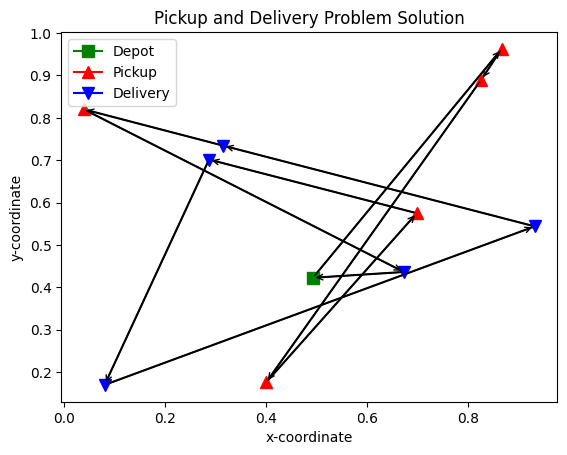

In [15]:
import matplotlib.pyplot as plt


markersize = 8

fig, ax = plt.subplots()

# Plot the actions in order
for i in range(len(actions_)):
    from_node = actions_[i]
    to_node = actions_[i+1] if i < len(actions_)-1 else actions_[0] # last goes back to depot
    from_loc = td_['locs'][from_node]
    to_loc = td_['locs'][to_node]
    ax.plot([from_loc[0], to_loc[0]], [from_loc[1], to_loc[1]], 'k-')
    ax.annotate("", xy=(to_loc[0], to_loc[1]), xytext=(from_loc[0], from_loc[1]),
                 arrowprops=dict(arrowstyle="->", color='black'), annotation_clip=False)

# Plot the depot location
ax.plot(depot_loc[0], depot_loc[1], "g", marker='s', markersize=markersize, label='Depot')

# Plot the pickup locations
for i, pickup_loc in enumerate(pickup_locs):
    ax.plot(pickup_loc[0], pickup_loc[1], 'r', marker='^', markersize=markersize, label='Pickup' if i == 0 else None)

# Plot the delivery locations
for i, delivery_loc in enumerate(delivery_locs):
    ax.plot(delivery_loc[0], delivery_loc[1], 'b', marker='v', markersize=markersize, label='Delivery' if i == 0 else None)

# Legend
# plt.legend(['Actions', 'Depot', 'Delivery', 'Pickup'])
# get handles
handles, labels = ax.get_legend_handles_labels()

# plot legend
ax.legend(handles, labels)
ax.set_title('Pickup and Delivery Problem Solution')
ax.set_xlabel('x-coordinate')
ax.set_ylabel('y-coordinate')
plt.show()